# Генерация текста с помощью RNN


(по мотивам [семинара](https://github.com/neychev/harbour_dlia2019/blob/master/day02_Simple_RNN/Day_2_Simple_RNN_pytorch.ipynb)
 [курса "Deep Learning in Applications"](https://in.harbour.space/data-science/deep-learning-in-applications-radoslav-neychev-anastasia-ianina/))

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output
from random import sample

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

# Данные
Датасет содержит ~9k имен, все написаны латиницей.

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
with open('russian_names.txt') as input_file:
    names = input_file.read()[:-1].split('\n')
    names = [' ' + line for line in names]  # add whitespace to each name as <BOS> symbol

In [ ]:
names[:5]

[' Ababko', ' Abaev', ' Abagyan', ' Abaidulin', ' Abaidullin']

Посмотрим на распределение длин имен:

In [ ]:
len(names)

9408

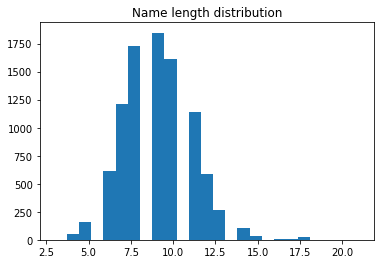

In [ ]:
plt.title('Name length distribution')
plt.hist(list(map(len, names)), bins=25);

# Препроцессинг

In [ ]:
#all unique characters go here
tokens = list(set(''.join(names)))

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  52


### Символы -> id

Создадим словарь < символ > -> < id >

In [ ]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [ ]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [ ]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [ ]:
#Example: cast 4 names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000], token_to_id))

 Ababko
 Chihachev
 Isaikov
 Nakhamkin
 Ustenko
[[37  6 13  3 13  9 33 37 37 37]
 [37 21 14 36 14  3 22 14 25  4]
 [37 16  8  3 36  9 33  4 37 37]
 [37 34  3  9 14  3 32  9 36 18]
 [37 48  8  7 25 18  9 33 37 37]]


In [ ]:
print(to_matrix(names[::2000], token_to_id).transpose(0,1))

[[37  6 13  3 13  9 33 37 37 37]
 [37 21 14 36 14  3 22 14 25  4]
 [37 16  8  3 36  9 33  4 37 37]
 [37 34  3  9 14  3 32  9 36 18]
 [37 48  8  7 25 18  9 33 37 37]]


# Рекуррентные нейронные сети

![img](https://raw.githubusercontent.com/Samsung-IT-Academy/stepik-dl-nlp/master/img/rnn.png)

In [ ]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units  # hid_size 
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, variable containing vector of int64
        :param h_prev: previous rnn hidden states, variable containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x) # [batch_size x emb_size]
        
        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([x_emb, h_prev], dim=1) # [batch_size x (emb_size + hid_size)] 
        h_next = self.rnn_update(x_and_h) # [batch_size x hid_size]
        
        h_next = F.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next) # [batch_size x [max_len, num_tokens] ] 
        
        return h_next, F.log_softmax(logits, dim=-1)
    
    def initial_state(self, batch_size):
        """ return h0 (rnn state before it processes first input)"""
        return Variable(torch.zeros(batch_size, self.num_units))

In [ ]:
char_rnn = CharRNNCell()

### Тренировка сети, RNN loop

In [ ]:
def rnn_loop(rnn_cell, names_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = names_ix.size()
    hid_state = rnn_cell.initial_state(batch_size)
    logprobs = []

    for x_t in names_ix.transpose(0,1):
        hid_state, logp_next = rnn_cell(x_t, hid_state)  
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

### Тренировка сети

In [ ]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

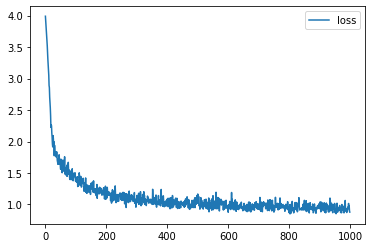

In [ ]:
MAX_LENGTH = max(map(len, names))

for i in range(1000):
    names_ix = to_matrix(sample(names, 32), token_to_id, max_len=MAX_LENGTH)
    names_ix = torch.tensor(names_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, names_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = names_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))   # minimizing cross-entropy (<=> maximizing log likelihood)
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # visualizing training process
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: генерация имен

In [ ]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        #print(f'x_sequence[:,-1]: {x_sequence[:,-1]}')
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        #print(f'p_next distribution === {p_next}')
        #print()
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    #print(x_sequence)
    #print(type(x_sequence))
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
for _ in range(10):
    print(generate_sample(char_rnn))

 Jyahlin             
 Topikh              
 Avaraskoff          
 Grentskhin          
 Ahepot              
 Voves               
 Jovtikhin           
 Gegetulonkin        
 Gilakinff           
 Kalin               


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase=' Kora', temperature=0.5))

 Korashin            
 Korakin             
 Korarov             
 Koranov             
 Koranin             
 Koranin             
 Korakov             
 Korakov             
 Koraev              
 Koraskov            


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


### Более простое решение

* `nn.RNNCell(emb_size, rnn_num_units)` - шаг RNN. Алгоритм: concat-linear-tanh
* `nn.RNN(emb_size, rnn_num_units` - весь rnn_loop.

Кроме того, в PyTorch есть `nn.LSTMCell`, `nn.LSTM`, `nn.GRUCell`, `nn.GRU`, etc. etc.

Перепишем наш пример с генерацией имен с помощью средств PyTorch.

In [55]:
class BasicModel(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, hid_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.gru = nn.GRU(emb_size, hid_size, batch_first=True)
        self.hid_to_logits = nn.Linear(hid_size, num_tokens)

    def forward(self, x, h_prev=None):
        """ predicts next hidden state h_t """
        assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        output, hn = self.gru(self.emb(x), h_prev) # [batch_size x [ MAX_LENGTH x hid_size ]] 
        # output: containing the output features (h_t) from the last layer of the GRU, for each t
        # hn: tensor containing the final hidden state for the input sequence.
        next_logits = self.hid_to_logits(output)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hn

In [ ]:
from IPython.display import clear_output
from random import sample

model = BasicModel(num_tokens=len(tokens))
opt = torch.optim.Adam(model.parameters())
history = []

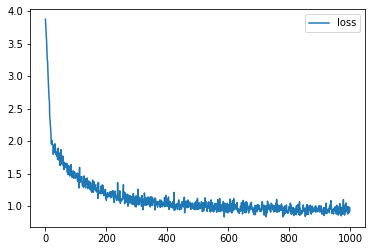

In [ ]:
MAX_LENGTH = max(map(len, names))

for i in range(1000):
    names_ix = to_matrix(sample(names, 32), token_to_id, max_len=MAX_LENGTH)
    names_ix = torch.tensor(names_ix, dtype=torch.int64)
    
    logp_seq, _ = model(names_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = names_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))   # minimizing cross-entropy (<=> maximizing log likelihood)
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # visualizing training process
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [ ]:
def generate_sample(model, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

    _, hn = model(x_sequence)
    hn = hn.squeeze(0)   
    
    # start generating
    for _ in range(max_length - len(seed_phrase)):
        logp_next, hn = model(x_sequence[:,-1], hn)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]

        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
for i in range(10):
    print(generate_sample(model, seed_phrase=' Vakhi')) # Trying to generate ' Vakhitov'

 Vakhin              
 Vakhinov            
 Vakhitov            
 Vakhihin            
 Vakhinnkrin         
 Vakhin              
 Vakhi               
 Vakhichabenky       
 Vakhin              
 Vakhikhen           


In [ ]:
for i in range(10):
    print(generate_sample(model, seed_phrase=' Kora', temperature=1.5)) # Getting ' Korablev' is extremely hard

 Koravsktsch         
 Korasilkov          
 Korakhan            
 Koratyaoejko        
 Koradov             
 KoraheanE           
 Koranokoff          
 Koratsovisp         
 Koraduskk           
 Korah               


In [ ]:
for i in range(10):
    print(generate_sample(model, seed_phrase=' Korabl', temperature=1.5)) # Got it!

 Korablichelevak     
 Korablkonetojejvylp 
 Korablahamov kyk    
 Korablev            
 Korablub            
 Korablov            
 Korablye            
 Korabliro Cch       
 Korabl              
 Korablrtenakpku     


In [ ]:
for i in range(10):
    print(generate_sample(model, temperature=0.1))

 Balin               
  alinov             
  alin               
 Malov               
 Malov               
 Palov               
 Malin               
 Maranov             
  alin               
  alin               


In [ ]:
for i in range(10):
    print(generate_sample(model, temperature=1))

  jrentovchenkov     
 Mesenukov           
 Batsuk              
 Lirkshuk            
 Bairman             
 Miulestov           
 Eistudor            
 Hammikik            
 Shakjem             
 Palin               


*   model can generate whitespace(' ') as a first letter in a name (``_jrentovchenkov``)  
__This may be caused by our training data__ (some samples were starting with a whitespace)

In [ ]:
# Let's investigate that issue:

cnt=0
for name in names:
    if name[1] == ' ':
        cnt+=1
cnt

0

In [ ]:
# Ok, that's not the case..

In [ ]:
# If we raise a temperature a little bit, the generated samples become more meaningless
for i in range(10):
    print(generate_sample(model, temperature=1.5))

 Ezitshchach hnykhsav
 Rip Zjowshyuwky     
 Vrtamovin           
 paanuhev            
 Iitsyyfc            
 Zhkhmn  ho          
  arodofs         k  
 Sltssanoffn c v     
 Fapuchskhi chichuv  
  adskevichdich Skau 


In [ ]:
# With temperature = 5 we get sequences without any sense
for i in range(10):
    print(generate_sample(model, temperature=5))

 MaI FugepgjimrfzaIjn
 e,KiLFpyNLi,kjVnshP,
 NNsLzddjkoIYDGdSurjz
 YJsoulsmeaffKAngLP d
 ,,sfmttotkhfVncNsbkz
 w'hI cBoEbeonSE eCpy
 ZbOKj K pneySIsch G 
 IUskweJbso  OiCovbyk
 ZKe'Jkroktja PIhneHv
 vAOgolBotsi VUilz kn


# Домашнее задание: мотивационные лозунги 

## S1. Character level approach

Генерируя цитаты на уровне символов, мы можем получать рандомные последовательности символов, которые вовсе не являются словами русского языка.</br>
Однако этот подход все равно представляет для нас практический интерес. (вдруг модель выучит словообразование и начнет предсказывать что-то внятное)

In [3]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
with open('/content/hw_author_quotes.txt') as input_file:
    quotes = input_file.read()[:-1].split('\n')
    quotes = [' ' + line.replace(u'\xa0', u' ') for line in quotes]

In [4]:
quotes[:5]

[' If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.',
 " Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think.",
 ' Did you ever stop to think, and forget to start again?',
 ' Organizing is what you do before you do something, so that when you do it, it is not all mixed up.',
 ' Weeds are flowers too, once you get to know them.']

In [5]:
tokens = list(set(''.join(quotes)))
token_to_id = {token: idx for idx, token in enumerate(tokens)} # character : idx
num_tokens = len(tokens) # 85 unique characters

(array([2.490e+02, 1.537e+03, 3.235e+03, 3.899e+03, 3.888e+03, 3.806e+03,
        2.946e+03, 2.343e+03, 2.135e+03, 2.137e+03, 1.849e+03, 1.610e+03,
        1.284e+03, 1.131e+03, 9.940e+02, 8.630e+02, 6.980e+02, 4.630e+02,
        3.970e+02, 3.430e+02, 2.700e+02, 8.100e+01, 1.000e+00, 2.000e+00,
        4.000e+00]),
 array([ 10.  ,  25.96,  41.92,  57.88,  73.84,  89.8 , 105.76, 121.72,
        137.68, 153.64, 169.6 , 185.56, 201.52, 217.48, 233.44, 249.4 ,
        265.36, 281.32, 297.28, 313.24, 329.2 , 345.16, 361.12, 377.08,
        393.04, 409.  ]),
 <a list of 25 Patch objects>)

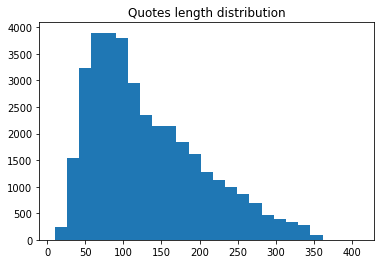

In [ ]:
plt.title('Quotes length distribution')
plt.hist(list(map(len, quotes)), bins=25)

In [ ]:
np.quantile(list(map(len, quotes)), 0.95)

275.0

In [ ]:
#Example: cast 5 quotes to matrices, pad with zeros
batch_lines = sorted(quotes, key=len)[5:10]
print('\n'.join(batch_lines[:5]))
print(to_matrix(batch_lines[:5], token_to_id))

 I love 'Glee.'
 I am reactive.
 I like horses!
 Keep it simple.
 To be is to do.
[[55  5 55 83 36 65 31 55 27 30 83 31 31 57 27 55]
 [55  5 55 62 35 55  0 31 62 53 66 54 65 31 57 55]
 [55  5 55 83 54  2 31 55 71 36  0 48 31 48  3 55]
 [55 23 31 31 17 55 54 66 55 48 54 35 17 83 31 57]
 [55 11 36 55 51 31 55 54 48 55 66 36 55  6 36 57]]


### Тренировка сети RNN 

In [ ]:
model = BasicModel(num_tokens=len(tokens))
opt = torch.optim.Adam(model.parameters())
history = []

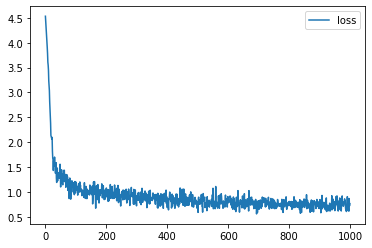

In [ ]:
MAX_LENGTH = max(map(len, quotes))

for i in range(1000):
    quotes_ix = to_matrix(sample(quotes, 32), token_to_id, max_len=MAX_LENGTH)
    quotes_ix = torch.tensor(quotes_ix, dtype=torch.int64)
    
    logp_seq, _ = model(quotes_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = quotes_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))   # minimizing cross-entropy (<=> maximizing log likelihood)
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # visualizing training process
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### Генерация цитат 

In [ ]:
MAX_LENGTH = max(map(len,quotes))

for i in range(10):
    print(generate_sample(model, max_length=MAX_LENGTH, seed_phrase=' I shouldn\'t have eaten that', temperature = 1)) 

 I shouldn't have eaten that bpinl,, hathte. I vess,. ach the nsace bat uat o y mom awd thateate, int Aem'd sactolerem; in asesg.                                                                                                                                                                                  £                                                                                                     
 I shouldn't have eaten thatut tert in moring jho cutuiony an of piot che helt perils fre wou whor e san e fallencin oreg gal forts imincar anlalel aplang hatinacud Dadid, be fosen lewnongmepe Waldting ito lepredo worloneloedyallled ile say bint dindhty to the'm thed  they whagU slesy ingmo wony bead beapliould a fritiy'ty a. Wher herty ous —uile mang ther, bese'ti'teve mirtener son  tha rarle fhoung bikc 
 I shouldn't have eaten thatemry is catl reeriy ppey nurt one tilibe  fid ofJonged dis chis bul ons nof afw'sily and, ot wo cingers ouce wror nalk yis hialr anesn to dsesf.+ san fa

In [ ]:
for i in range(10):
    print(generate_sample(model, max_length=50, seed_phrase=' ', temperature = 0.9)) 

 The .                                            
 porer ther theciys on ther bacg sol hyean in asre
 ho te batil en orht tan lom eaysel te wulaps in w
 Cow ulisl poaya ive the. n  a dot covet jevestys 
 Ren. I wual ind ther tin tibt a's lower. bers mok
 4                                                
                                                  
 I vome fomrides wis maree shatnresteedontimfe low
 Ae tan in then.                                  
 fn we ant reveitep gi- anes'cle eabped coil al w 


In [ ]:
# Let's give it a starting phrase

for i in range(10):
    print(generate_sample(model, max_length=MAX_LENGTH, seed_phrase=' Thou art I ', temperature = 0.5)) # thou art I and I am thou

 Thou art I a lat meore cowing hor ar in wal ap as at of in the more on tiat and the sis and and the the wheal and are the har at the wyor of that the the lig ar1 the there to  and and and a dot an that an hes at gor an enen to g man wher the aly thor eling the ass be and the o pat and int in that mong me wout to wo mare and whit e han wat I the to to ing the persis sor ous the wo the the the of of the the
 Thou art I in the douting and then of and Ind in an of of the whe wher the anden wou and ther the whe mus the the siske hire the then ale whers o wo dor frerat the the mome the the what as il wor coren the doust rout a ty that hes the that an that thot the the he the and and the dout wo the and and the meall and and werove me the be so the go to the and that pare the what ar the thoud wand wee the I lad s
 Thou art I and hat ther of the sing the to the the the sronge hos at and the lion areve the wout the the ing on and move an bemere in restor of wo more the of saf. I tuw in the th

In [ ]:
for i in range(10):
    print(generate_sample(model, max_length=24, seed_phrase=' Thou art I ', temperature = 1)) # thou art I and I am thou

 Thou art I tos sot ,uve
 Thou art I thau.       
 Thou art I mant ay caut
 Thou art I utot muc gul
 Thou art I s if oud -to
 Thou art I moty an wer 
 Thou art I aresive nobc
 Thou art I a bocens ham
 Thou art I and ches ine
 Thou art I Woble.pratas


In [ ]:
# Let's give it a starting phrase
%%time
out_phrase=''
while (out_phrase[:17] != ' Thou art I and I'): 
    out_phrase = generate_sample(model, max_length=24, seed_phrase=' Thou art I ', temperature = 1.5)
print(out_phrase)

 Thou art I and ILio chd
CPU times: user 1min 39s, sys: 253 ms, total: 1min 39s
Wall time: 1min 40s


In [ ]:
# Not what I expected, but it was a complicated example (at least character-level model couldn't handle it)

In [ ]:
# Maybe lowering the temperature we'll produce it faster (?)
%%time
out_phrase=''
while (out_phrase[:17] != ' Thou art I and I'): 
    out_phrase = generate_sample(model, max_length=24, seed_phrase=' Thou art I ', temperature = 1)
print(out_phrase)

 Thou art I and I'sind n
CPU times: user 9.18 s, sys: 26.5 ms, total: 9.21 s
Wall time: 9.22 s


In [ ]:
# Maybe changing the max_len will help us getting more sophisticated result
%%time
out_phrase=''
for i in range(10): 
    print(generate_sample(model, max_length=MAX_LENGTH, seed_phrase=' Thou art I ', temperature = 1))

 Thou art I ankeur, till beast athen macu tore toh wor aspe thal asy grey. Womigkas fat' or yowd don ast ang hrour irinten to                                                                                                                                                                                                                                                                                            
 Thou art I hul roove on fhebippime atolive moon has thin wo mart inelteoto anding youc thed.                                                                                                                                                                                                                                                                                                                            
 Thou art I a komeog he out rile wofene hich aNt in inct man't has whowind ifut ande sringe I fentire not rabe sory sere wores is ot oid tou ariibe bede. 9  0                      

## S2. Segment-level approach

### Tokenizing

In [7]:
!pip3 install subword-nmt &> log

In [8]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

In [9]:
quotes[:5]

[' If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.',
 " Promise me you'll always remember: You're braver than you believe, and stronger than you seem, and smarter than you think.",
 ' Did you ever stop to think, and forget to start again?',
 ' Organizing is what you do before you do something, so that when you do it, it is not all mixed up.',
 ' Weeds are flowers too, once you get to know them.']

In [10]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('tokenized_quotes.txt', 'w') as f_quotes:
    for quote in quotes:
        f_quotes.write(' ' + tokenize(quote.strip()) + '\n')

In [ ]:
!head -n 10 tokenized_quotes.txt

 if you live to be a hundred , i want to live to be a hundred minus one day so i never have to live without you .
 promise me you ' ll always remember : you ' re braver than you believe , and stronger than you seem , and smarter than you think .
 did you ever stop to think , and forget to start again ?
 organizing is what you do before you do something , so that when you do it , it is not all mixed up .
 weeds are flowers too , once you get to know them .
 you can ' t stay in your corner of the forest waiting for others to come to you . you have to go to them sometimes .
 the third - rate mind is only happy when it is thinking with the majority . the second - rate mind is only happy when it is thinking with the minority . the first - rate mind is only happy when it is thinking .
 bores can be divided into two classes ; those who have their own particular subject , and those who do not need a subject .
 what i say is that , if a fellow really likes potatoes , he must be a pretty decent 

In [11]:
# build and apply bpe vocs

learn_bpe(open('/content/tokenized_quotes.txt'), open('bpe_rules', 'w'), num_symbols=10000)  # 1. learn_bpe rules 
bpe = BPE(open('./bpe_rules'))  # 2. create instance of BPE class

with open('quotes.bpe', 'w') as f_out:
    for line in open('/content/tokenized_quotes.txt'):
        f_out.write(bpe.process_line(line.strip()) + '\n')  # 3. apply BPE tokenization to our data

100%|██████████| 10000/10000 [00:17<00:00, 579.24it/s]


### Building vocabularies

In [12]:
# 8k merges looks fine, maybe tune that hyperparameter later (idk how though)
data = np.array(open('/content/quotes.bpe').read().split('\n'))

for i in range(10):
    print('quote:', data[i], end='\n')

quote: if you live to be a hundred , i want to live to be a hundred min@@ us one day so i never have to live without you .
quote: promise me you ' ll always remember : you ' re bra@@ ver than you believe , and stronger than you seem , and smarter than you think .
quote: did you ever stop to think , and forget to start again ?
quote: organi@@ zing is what you do before you do something , so that when you do it , it is not all mixed up .
quote: wee@@ ds are flowers too , once you get to know them .
quote: you can ' t stay in your corner of the forest waiting for others to come to you . you have to go to them sometimes .
quote: the third - rate mind is only happy when it is thinking with the majority . the second - rate mind is only happy when it is thinking with the minority . the first - rate mind is only happy when it is thinking .
quote: bo@@ res can be divided into two classes ; those who have their own particular subject , and those who do not need a subject .
quote: what i say is t

In [13]:
from vocab import Vocab
voc = Vocab.from_lines(data) # creates an instance of Vocab class from train data

In [14]:
len(voc)

9562

In [ ]:
# Here's how you cast lines into ids and backwards.
batch_lines = sorted(data, key=len)[5:10]
batch_ids = voc.to_matrix(batch_lines)
batch_lines_restored = voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['to be is to do .', 'a win is a win .', 'the die is cast .', 'i love to write .', 'i am re@@ active .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 4579,  501, 2458, 4579, 1337,   27,    1],
        [   0,   86, 4932, 2458,   86, 4932,   27,    1],
        [   0, 4476, 1269, 2458,  728,   27,    1,    1],
        [   0, 2261, 2763, 4579, 4987,   27,    1,    1],
        [   0, 2261,  265, 3645,  151,   27,    1,    1]])

back to words
['to be is to do .', 'a win is a win .', 'the die is cast .', 'i love to write .', 'i am re@@ active .']


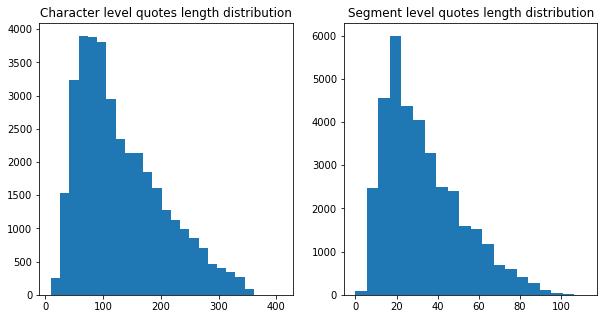

In [ ]:
# Previously we had character-level distribution
plt.figure(figsize=[10, 5])

plt.subplot(1,2,1)
plt.title('Character level quotes length distribution')
plt.hist(list(map(len, quotes)), bins=25)

# Now we have BPE tokenized quotes
plt.subplot(1,2,2)
plt.title("Segment level quotes length distribution")
plt.hist(list(map(len, map(str.split, data))), bins=20);

### Train RNN model

In [66]:
model = BasicModel(num_tokens=len(voc))
opt = torch.optim.Adam(model.parameters())
history = []

In [53]:
data = np.squeeze(data).tolist() # to cast it to a simple list, not np.array

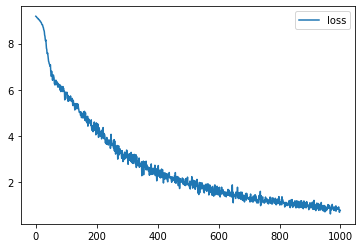

CPU times: user 9min 36s, sys: 8.85 s, total: 9min 44s
Wall time: 9min 44s


In [67]:
%%time

MAX_LENGTH = max(list(map(len, map(str.split, data)))) # 107 (num_symbols = 8000)

for i in range(1000):
    batch_lines = sample(data, 32)
    batch_ix = voc.to_matrix(batch_lines, dtype=torch.int64, max_len=MAX_LENGTH) # batch_ix - target indeces (want to predict them)

    targets_1hot = F.one_hot(batch_ix, len(voc)).to(torch.float32)
    
    # compute mask 
    mask = voc.compute_mask(batch_ix) # [batch_size, out_len]
    
    logp_seq, _ = model(batch_ix)

    logp_out = (logp_seq * targets_1hot).sum(dim=-1)  

    # compute loss

    #loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))   # minimizing cross-entropy (<=> maximizing log likelihood)
    loss = -logp_out[mask].mean()
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    # visualizing training process
    history.append(loss.data.numpy())
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### Генерация цитат 

In [23]:
def generate_sample_bpe(model, seed_phrase='', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    # 1. Tokenize the seed_phrase using bpe.rules
    if (seed_phrase.strip() != ''):
        # preprocess seed_phrase and generate h0 for decoder
        line = bpe.process_line(seed_phrase.lower().strip())
        #print(f'Tokenized line = {line}')
        x_sequence = voc.to_matrix([line]) # tensor([[0, 150, 120, 2, ..., 45, 40, 1]])
        
        # get rid of last PAD since we want to continue the phrase
        x_sequence = x_sequence[:,:-1] # tensor([[0, 150, 120, 2, ..., 45, 40]])

        length = x_sequence.size()[1]
        
        _, hn = model(x_sequence[:,:-1]) # take only tensor([[0, 150, 120, 2, ..., 45]])
                                       # 40 goes as a first input in decoder
        #print(hn.size())
        hn = hn.squeeze(0)       
    else:
        # No seed_phrase => starting with <BOS>
        x_sequence = torch.zeros([1,1],dtype=torch.int64) 
        length = 0
        hn = None
    
    # start generating
    for _ in range(max_length - length):
        logp_next, hn = model(x_sequence[:,-1], hn) 
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]

        next_ix = np.random.choice(len(voc), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    #return x_sequence
    return voc.to_lines(x_sequence)
    #return ''.join([voc.token_to_ix[ix] for ix in x_sequence.data.numpy()[0]])

In [70]:
for i in range(10):
    print(generate_sample_bpe(model, seed_phrase='', temperature=2))

['seven@@ tually dimini@@ boy tv haven rela@@ oms harb@@ reci@@ dre@@ ding c thered my relative petty democrat stare skinny wet crash thing confront er writers expression 5@@ sc@@ hard managed entertaining laun@@ criticism rish chicken moves forgive joan aca@@ begin tell thee cy@@ tional ken@@ magic 45 passengers anti companionship efly restric@@ cla@@ genre performing girl cats i@@ filled stop cheer cc@@ rare western doubts 40 fam@@ t semble hop@@ gone 24 expres@@ level crit@@ opinion smarter arrive pause national increased treasures under@@ planes certainly becoming click presses gru@@ udi@@ neighborhood requires seniors model decade am part@@ score adventure master cases']
["introdu@@ your sleep mers follow en@@ nearer satisfaction appear decline sa@@ perpetually seattle needed served ( fascinating embar@@ fa@@ ing arranged letter obligation born tur@@ dently 16 o@@ john sk@@ someday door price selfishness daughters broke shak@@ dri@@ passion tics prolet@@ bars ' gamb@@ reinvent con

### Генерация ситат (Model without attention)

In [88]:
bpe_sep = '@@'

for i in range(10):
    print(''.join(generate_sample_bpe(model, seed_phrase='Have you ever been in', temperature=2, max_length=20)).replace(bpe_sep,''))

have you ever been in egypt connery principle crimes insecurity knew studied imaginative alized husband designers lake resources bil
have you ever been in irony sition fast fixed dramatic heritage planned il orial ge s karma li numbers
have you ever been in internet certainly 9 better intellectual ly ticity sovereignty ment quick ni except ferrar library
have you ever been in tail partner asking ceased afterlife interact tures thinking stores mental survival gave trans adi
have you ever been in students law uniqu accounting horse instrument medicine imagine realise joy carry station run these
have you ever been in use use marked younger jim crime star istics dangerous dated below similar prevail fitting
have you ever been in speech sions forgive ten shape confused persons fall struc xes affe arch legend est
have you ever been in his served activity discovered ga princip constitution system office syri anchor lion basically diplomatic
have you ever been in lin approach ve turtle render 

In [93]:
bpe_sep = '@@'

for i in range(10):
    print(''.join(generate_sample_bpe(model, seed_phrase='Have you ever been in', temperature=2, max_length=10)).replace(bpe_sep,''))

# have you ever been in ass ? 

have you ever been in difficulty mble thousands comic
have you ever been in in fi control but
have you ever been in perfectly resolved didn didn
have you ever been in machine impati ho upper
have you ever been in ass result future whil
have you ever been in studied let y golden
have you ever been in audiences creative breeds 1964
have you ever been in sed revenge graph recol
have you ever been in dedicated business wrest co
have you ever been in records if illumin support


In [116]:
bpe_sep = '@@'

for i in range(10):
    print(''.join(generate_sample_bpe(model, seed_phrase='There is no point in', temperature=100)).replace(bpe_sep,''))

# there is no point in humans 

there is no point in gla dignity launched gned fur maximum plan grasp hibi co p aspira musician pas followed realities fes ti hole belon bikes richer po about lic painted ro ool stroke rot changeable bush narrow basic casual down skill line atic irrational conservative pie sman att retirement motive immigration rela backward femin mas ket agree fulfillment format disa lat dog drums super som about c viewing theologians bos organization maximum gn pattern trying covers founded im ge grass revenue ill prece dan mits leaders town tlene illers allo k regrets winter found news marvelous ouring pin hatred pajamas
there is no point in fur destructive bas maternal chi mend racing presence rifle illi 2 affection address enjoyment educated - advocate rebellion resolution broadcast wall contemp skyscra visu roo difficult bringing consi exce authen voc how topshop er road portions loneliness vali sal pushes none tives tuition objec iraq rap bi whom q stu tennis jud tom dece trap army realize tren 

In [142]:
for i in range(10):
    print(''.join(generate_sample_bpe(model, seed_phrase='Having no sex is', temperature=2, max_length=20)).replace('@@',''))

# having no sex is sport technique (Guess I'm an athlete then)    

having no sex is slow contr iraq closely comp morality servant sk min when reduce here stamina femini motor
having no sex is sport technique poverty chy ick w wrin beliefs recording fi starter offer theatre emo wa
having no sex is club someday singers model pled sten slowly earthly presenting implications fish fam studies emotion abroad
having no sex is is ! meth camera for shop though ght mere got theaters essentially cor interpretation vi
having no sex is sion bother y rein freedom literally honor institution playoffs town nostalgia question nob muscles ordinary
having no sex is cking amate reli rist assi routine changing om differ extre structure train mingly basically later
having no sex is is tr mb veh putting soap temperam conception strange offer question convince accomplishment rush bit
having no sex is bin dinner sting shutter edu ari pink fired concepts productive ily ona techn mistakes with
having no sex is questions sin mighty heroic scar existence hoped costume serbia old 

In [154]:
for i in range(10):
    print(''.join(generate_sample_bpe(model, seed_phrase='Having no sex is', temperature=2, max_length=20)).replace('@@',''))

# having no sex is original essence (of) international progress

having no sex is is fingers no fast tionists k flowers tish expression youth policy despair mate races ton
having no sex is person chose course rolls ap everything tend each ?' strictly talk way taken fast beg
having no sex is lightful igns drinking roles ing too pre longer happened recall friend ge work lot sters
having no sex is original essence international progress show soci positive tum atlan prejudice addi sunny ko pu lic
having no sex is is film convince ach wisdom athlete noticing obsession secre rish walking throw touch imperson leader
having no sex is is personalities objective arthur seldom ad on aded lin vegas trau simplicity sca nothingness dise
having no sex is sees stupidity cho assi several mine latin forgi dysfunctional light privately yeah prus hydrogen why
having no sex is ju actress
having no sex is talk accomplish mped ! masculinity account diverse dog relationship flexi ir deb imp sexuality california
having no sex is hour respond thir of poem bigger poe library 

### Что еще можно генерировать?
С помощью кода из этого семинара можно генерировать не только имена, но и:

* Повести/романы/поэзию/песни любимого автора
* Новостные заголовки
* Программный код
* Молекулы в формате [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)
* Музыку
* Названия мебели из ИКЕА
* Мотивационные лозунги
* etc.

__Удачи!__